In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data exploration libraries
from requests import get
from io import StringIO
from ydata_profiling import ProfileReport
from IPython.display import HTML

# ML libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

C:\Users\User\AppData\Local\Temp\ipykernel_1768\2232924586.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
url = "https://storage.googleapis.com/the_public_bucket/wine-clustering.csv" # Direct link to the dataset
response = get(url)

if response.status_code == 200:
    data = pd.read_csv(StringIO(response.text)) # Dataframe from the csv file
    print('Data retrieved successfully')
else:
    print(f"Failed to download dataset. Status code: {response.status_code}")

data.head(2)
print(data.shape)

Data retrieved successfully
(178, 13)


# Clustering analysis tests

In [3]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data)

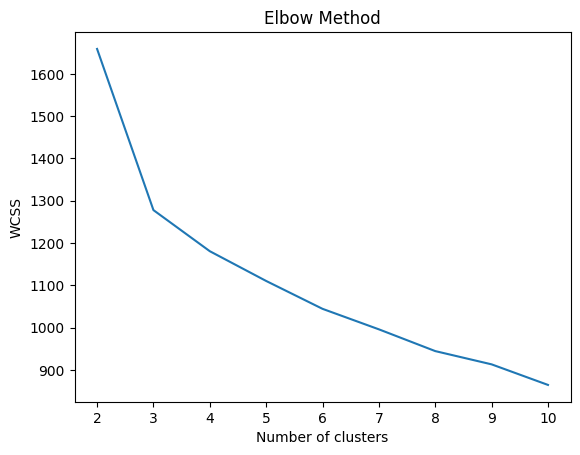

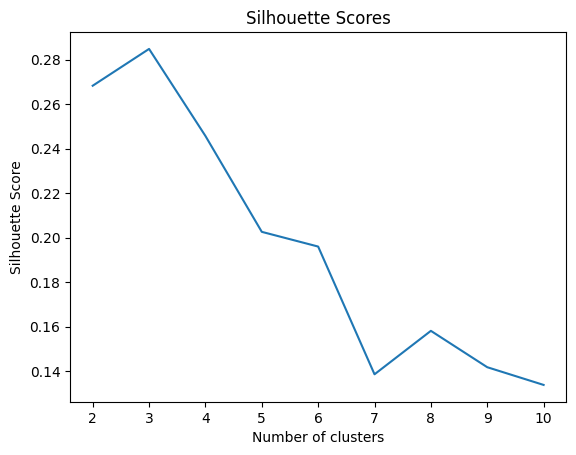

In [4]:
%matplotlib inline
wcss = []
silhouette_scores = []

max_clusters = 10

for i in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

plt.plot(range(2, max_clusters+1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(2, max_clusters+1), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [5]:
optimal_clusters = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df_scaled)

In [6]:
data['Cluster'] = pred_y
data.groupby('Cluster').mean()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Cluster,,,,,,,,,,,,,
0,12.250923,1.897385,2.231231,20.063077,92.738462,2.247692,2.050000,0.357692,1.624154,2.973077,1.062708,2.803385,510.169231
1,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824
2,13.676774,1.997903,2.466290,17.462903,107.967742,2.847581,3.003226,0.292097,1.922097,5.453548,1.065484,3.163387,1100.225806


Model evaluation

In [7]:
X = data.drop('Cluster', axis=1)
y = data['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [9]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [10]:
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 9  4  0]
 [ 2  6  1]
 [ 0  2 12]]
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.50      0.67      0.57         9
           2       0.92      0.86      0.89        14

    accuracy                           0.75        36
   macro avg       0.75      0.74      0.74        36
weighted avg       0.78      0.75      0.76        36

